# Objective:
### To build a DT classifier to predict rating_class (from numerical average_rating by binning) 
# Potential input features: 
### certificate (categorical), runtime (numerical), genre (multi label categorical), metascore (numerical), critic_count (numerical), review_count (numerical), awards (mixed, to be split into multiple numerical features), budget (numerical)

##### note: Initial idea is to use metascore ( > 89% NA) as target. Change to average_rating (~53% NA)
##### note: One concern was overlooked during crawling, unreleased / planned / in production movies (as well as other video type, such as trailer, short clips etc) are all crawled but no relavent feature is recorded, hence increases NA rates for most features. Rows with NA for certain features need to be dropped


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from ast import literal_eval

In [2]:
movies = pd.read_csv('data/movies.csv', index_col = 0)
movies.sample(5)

,name,url,year,certificate,runtime,genre,average_rating,metascore,review_url,movie_id,critic_count,review_count,directors,writers,stars,awards,budget,us_opening,us_gross,worldwide_gross
3191,Some Smoke and a Red Locker,/title/tt10739024/?ref_=adv_li_tt,2019,NaN,93 min,"['Comedy', 'Fantasy', 'Sci-Fi']",NaN,NaN,/title/tt10739024/reviews,tt10739024,NaN,NaN,['nm7509008'],['nm7509008'],"['nm5588727', 'nm7160289', 'nm0862975']",[],NaN,NaN,NaN,NaN
254,Paradise Beach,/title/tt7511008/?ref_=adv_li_tt,2019,NaN,93 min,"['Action', 'Thriller']",4.5,NaN,/title/tt7511008/reviews,tt7511008,8 critic,43 user,['nm0244378'],"['nm0244378', 'nm0585855']","['nm0098793', 'nm0416126', 'nm0235461']",[],NaN,NaN,NaN,"Cumulative Worldwide Gross: $186,410"
3753,Homecoming,/title/tt2458398/?ref_=adv_li_tt,2019,NaN,99 min,"['Horror', 'Thriller']",4.6,NaN,/title/tt2458398/reviews,tt2458398,NaN,3 user,['nm1729135'],[],"['nm0067768', 'nm0296870', 'nm1435292']",[],"Budget:$1,500,000\n (estimated)",NaN,NaN,NaN
4223,The Escape Artists,/title/tt12246472/?ref_=adv_li_tt,2019,NaN,NaN,['Music'],NaN,NaN,/title/tt12246472/reviews,tt12246472,NaN,NaN,['nm7490334'],[],"['nm11543942', 'nm11544882', 'nm11544884']",[],NaN,NaN,NaN,NaN
4636,Just Speechless,/title/tt12551260/?ref_=adv_li_tt,2020,NaN,87 min,"['Crime', 'Drama', 'Mystery']",8.6,NaN,/title/tt12551260/reviews,tt12551260,NaN,NaN,[],['nm11675032'],[],[],NaN,NaN,NaN,NaN


In [3]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5478 entries, 0 to 5477
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             5478 non-null   object 
 1   url              5478 non-null   object 
 2   year             5478 non-null   int64  
 3   certificate      598 non-null    object 
 4   runtime          3498 non-null   object 
 5   genre            5478 non-null   object 
 6   average_rating   2577 non-null   float64
 7   metascore        589 non-null    float64
 8   review_url       5478 non-null   object 
 9   movie_id         5478 non-null   object 
 10  critic_count     2020 non-null   object 
 11  review_count     2132 non-null   object 
 12  directors        5478 non-null   object 
 13  writers          5478 non-null   object 
 14  stars            5478 non-null   object 
 15  awards           5478 non-null   object 
 16  budget           1836 non-null   object 
 17  us_opening    

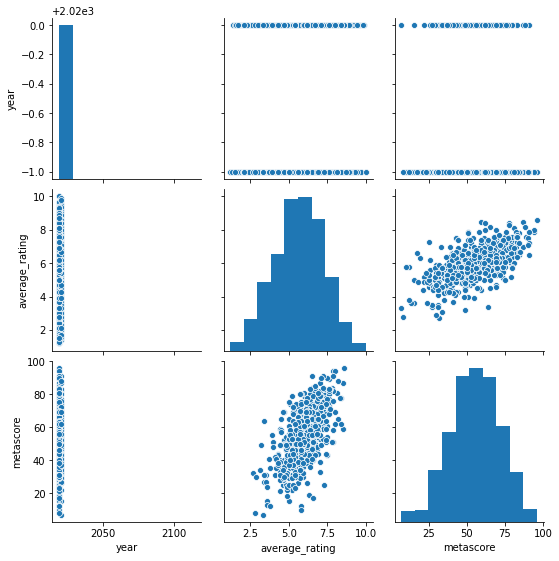

In [4]:
sns.pairplot(movies)

# Feature selection
### For all numerical features, group them into different categorical classes using binning technique

## 1. Target Classifier - rating_class (created from average_rating, 0 - 10)

In [5]:
movies['average_rating'].describe()
#movies['average_rating'].isna().sum()

# drop rows with NA average_rating
movies.dropna(subset = ['average_rating'], inplace = True)

# # or fill NA with -1 (if 'Not Rated' is taken as a category) -- not considered, lowered the model accuracy
# movies['average_rating'].fillna(-1, inplace = True)

# groupped as categorical feature
movies['rating_class'] = pd.cut(
    movies['average_rating'], 
    bins = [-10, 0, 2.5, 5, 7.5, 10], 
    labels = ['Not rated', 'Terrible', 'Poor', 'Average', 'Excellent']
)

movies[movies['average_rating']>-1].sample(10)[['average_rating', 'rating_class']]


,average_rating,rating_class
301,6.0,Average
4936,6.1,Average
1669,6.9,Average
2775,6.4,Average
2395,6.1,Average
864,4.1,Poor
4178,6.1,Average
2137,4.6,Poor
714,4.9,Poor
2476,6.5,Average


## 2. metascore_class (created from metascore, 0 - 100)

In [6]:
# metascore is the official rating of the movie used in imdb

movies['metascore'].describe()
#movies['metascore'].isna().sum()

# fill NA with -1 (to be groupped as 'Not Rated')
movies['metascore'].fillna(-1, inplace = True)

# groupped as categorical feature
movies['metascore_class'] = pd.cut(
    movies['metascore'], 
    bins = [-10, 0, 25, 50, 75, 100], 
    labels = ['Not rated', 'Terrible', 'Poor', 'Average', 'Excellent']
)

movies.sample(10)[['metascore', 'metascore_class']]


,metascore,metascore_class
4162,-1.0,Not rated
223,-1.0,Not rated
740,60.0,Average
4194,-1.0,Not rated
743,-1.0,Not rated
3902,-1.0,Not rated
2082,-1.0,Not rated
2729,50.0,Poor
1894,-1.0,Not rated
2307,-1.0,Not rated


## 3. certificate

In [7]:
# fill na as Not Rated
movies['certificate'].fillna('Not Rated', inplace = True)
movies['certificate'].value_counts()


Not Rated    2058
R             255
PG-13          81
P13            64
PG             59
18             44
U               7
G               6
(Banned)        3
Name: certificate, dtype: int64

## 4. length (created from runtime)

In [8]:
# explore runtime content
movies['runtime'].unique()

array(['148 min', '90 min', '113 min', '181 min', '93 min', '116 min',
       '142 min', '109 min', '124 min', '117 min', '123 min', '152 min',
       '135 min', '99 min', '98 min', '118 min', '137 min', '122 min',
       '86 min', '95 min', '129 min', '102 min', '130 min', '138 min',
       '128 min', '132 min', '111 min', '121 min', '89 min', '120 min',
       '97 min', '114 min', '125 min', '92 min', '107 min', '108 min',
       '100 min', '104 min', '101 min', '119 min', '87 min', '80 min',
       '88 min', '110 min', '140 min', '112 min', '96 min', '82 min',
       '84 min', '91 min', '94 min', '103 min', '105 min', '83 min',
       '154 min', nan, '72 min', '126 min', '78 min', '85 min', '170 min',
       '77 min', '106 min', '68 min', '115 min', '81 min', '153 min',
       '136 min', '75 min', '70 min', '76 min', '71 min', '146 min',
       '73 min', '134 min', '180 min', '143 min', '60 min', '147 min',
       '79 min', '48 min', '127 min', '61 min', '16 min', '57 min',
       '

In [9]:
# values comes with unit (min), extract only the numbers and fill na with 0
movies['runtime'] = movies['runtime'].str.extract('(\d+)').fillna("-1").astype(int)

# thrillers, short clips etc are found, drop all rows with 60minutes or less in lenght
movies = movies[movies['runtime'] > 60]

# groupped as categorical feature
movies['length'] = pd.cut(
    movies['runtime'], 
    bins = [-10, 0, 90, 150, 500], 
    labels = ['Not Specified', 'Short', 'Average', 'Long']
)
movies.sample(10)[['name', 'runtime', 'length']]



/home/kitlim/py3_kernel/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,name,runtime,length
2874,The Zombie Club,91,Average
2708,¿A quién te llevarías a una isla desierta?,93,Average
2239,Oracabessa,113,Average
3808,Gravedigger Dave's Halfway House,72,Short
5291,Evening Installation,80,Short
1918,The Barefoot Emperor,98,Average
3917,Unholy Night,85,Short
3550,Fried Barry,99,Average
2733,Escape and Evasion,92,Average
2252,From Iceland to EDEN,85,Short


## 5. genre (multi label - split into individual categorical feature)

In [10]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# parse genre (string) as array
movies['genre'] = movies['genre'].apply(literal_eval)

# transform genres into individual binary categories
movies = movies.join(
    pd.DataFrame(mlb.fit_transform(movies.pop('genre')), columns = mlb.classes_, index = movies.index)
)

movies.sample(5)



/home/kitlim/py3_kernel/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,name,url,year,certificate,runtime,average_rating,metascore,review_url,movie_id,critic_count,...,Music,Musical,Mystery,Reality-TV,Romance,Sci-Fi,Sport,Thriller,War,Western
2844,Christmas Cars,/title/tt11437784/?ref_=adv_li_tt,2019,Not Rated,99,2.2,-1.0,/title/tt11437784/reviews,tt11437784,NaN,...,0,0,0,0,0,0,0,0,0,0
3669,Return to Horror Hotel,/title/tt10581102/?ref_=adv_li_tt,2019,Not Rated,83,4.1,-1.0,/title/tt10581102/reviews,tt10581102,5 critic,...,0,0,0,0,0,1,0,0,0,0
1977,Weedjies: Halloweed Night,/title/tt10514312/?ref_=adv_li_tt,2019,Not Rated,75,4.8,-1.0,/title/tt10514312/reviews,tt10514312,3 critic,...,0,0,0,0,0,0,0,0,0,0
1705,Rare Beasts,/title/tt8419594/?ref_=adv_li_tt,2019,Not Rated,87,6.6,-1.0,/title/tt8419594/reviews,tt8419594,8 critic,...,0,0,0,0,1,0,0,0,0,0
2703,Goldie,/title/tt7335104/?ref_=adv_li_tt,2019,Not Rated,88,5.3,72.0,/title/tt7335104/reviews,tt7335104,14 critic,...,0,0,0,0,0,0,0,0,0,0


## 6. critic_popularity (created from critic_count, top 90% = Hot, else Not Popular)

In [11]:
# values were appended with strings, extract only the numbers and fill na with 0
movies['critic_count'] = movies['critic_count'].str.replace(',', '').str.extract('(\d+)').fillna("0").astype(int)

# movies.sort_values('critic_count')[['name', 'critic_count']]
# sns.distplot(movies['critic_count'])

# groupped as categorical feature
movies['critic_popularity'] = pd.qcut(
    movies['critic_count'], q = [0, .9, 1], labels = ['Not Popular', 'Hot']
)

movies[['name', 'critic_count', 'critic_popularity']].head()

,name,critic_count,critic_popularity
1,The Last Days of American Crime,55,Not Popular
2,The Hunt,209,Hot
3,The Gentlemen,247,Hot
4,Avengers: Endgame,551,Hot
5,Becky,75,Hot


## 7. review_popularity (created from review_count, top 90% = Hot, else Not Popular)

In [12]:
# values appended with string, extract only the numbers and fill na with 0
movies['review_count'] = movies['review_count'].str.replace(',', '').str.extract('(\d+)').fillna("0").astype(int)

# movies.sort_values('review_count')[['name', 'review_count']]
# sns.distplot(movies['review_count'])

# groupped as categorical feature
movies['review_popularity'] = pd.qcut(
    movies['review_count'], q = [0, .9, 1], labels = ['Not Popular', 'Hot']
)

movies[['name', 'review_count', 'review_popularity']].head()


,name,review_count,review_popularity
1,The Last Days of American Crime,294,Hot
2,The Hunt,639,Hot
3,The Gentlemen,1058,Hot
4,Avengers: Endgame,8784,Hot
5,Becky,151,Not Popular


## 8. achievement (created from awards)

In [13]:
# explore awards content (random sample)
for award in movies[movies['awards'] != '[]'].head(20)['awards'].iteritems():
    print(award)
    

(4, "['Nominated for\\n            1\\n            Oscar.', 'Another\\n        65 wins & 103 nominations.']")
(8, "['Nominated for\\n            3\\n            Oscars.', 'Another\\n        7 wins & 35 nominations.']")
(9, "['3 nominations.']")
(11, "['1 nomination.']")
(14, "['1 win & 5 nominations.']")
(16, "['1 win & 5 nominations.']")
(19, "['Won\\n            2\\n            Oscars.', 'Another\\n        21 wins & 73 nominations.']")
(20, "['3 wins & 4 nominations.']")
(22, "['1 nomination.']")
(26, "['1 win & 6 nominations.']")
(28, "['1 win & 20 nominations.']")
(29, "['9 wins & 25 nominations.']")
(33, "['9 wins & 21 nominations.']")
(36, "['12 wins & 27 nominations.']")
(38, "['1 nomination.']")
(39, "['7 wins & 46 nominations.']")
(40, "['1 win & 7 nominations.']")
(41, "['9 nominations.']")
(45, "['2 nominations.']")
(47, "['21 nominations.']")


In [14]:
# categorize achievement based on awards content
def get_achievement (award_string):
    
    # parse awards (string) as array
    awards = literal_eval(award_string)
    
    if len(awards) == 0:
        return "None"
    elif len(awards) == 1:
        if awards[0].lower().find("win") != -1:
            return "Won Common Awards"
        elif awards[0].lower().find("nomination") != -1:
            return "Nominated Common Awards"
    elif len(awards) > 1:
        if awards[0].lower().find("won") != -1:
            return "Won Major Awards"
        if awards[0].lower().find("nominated") != -1:
            if awards[1].lower().find("win") != -1:
                return "Won Common Awards"
            else:
                return "Nominated Major Awards"
    

# assign category to achievement based on awards
movies['achievement'] = movies['awards'].apply(get_achievement)
movies.sample(10)[['name', 'awards', 'achievement']]

,name,awards,achievement
4463,Derelict,[],None
528,Finding Purpose: The Road to Redemption,['1 win.'],Won Common Awards
539,Blood & Oil,[],None
1417,Dream Horse,[],None
3390,Daniel Isn't Real,['5 wins & 4 nominations.'],Won Common Awards
1730,Palm Beach,['1 nomination.'],Nominated Common Awards
2779,The Message,[],None
2789,Heavy,[],None
2424,Never Rarely Sometimes Always,['3 wins & 2 nominations.'],Won Common Awards
3522,Dead Dicks,['4 wins & 1 nomination.'],Won Common Awards


## 8. high_cost_production (created from budget, above USD 100 Million)

In [15]:
# explore awards content
movies[['budget']].head(10)

,budget
1,NaN
2,"Budget:$14,000,000\n (estimated)"
3,"Budget:$22,000,000\n (estimated)"
4,"Budget:$356,000,000\n (estimated)"
5,NaN
7,NaN
8,"Budget:$275,000,000\n (estimated)"
9,"Budget:$84,500,000\n (estimated)"
11,"Budget:$90,000,000\n (estimated)"
14,"Budget:$138,000,000\n (estimated)"


In [16]:
# convert from string to integer, coerced as NaN for those not USD, 
movies['budget_usd'] = movies['budget'].str.lower().str.lstrip('budget:').str.rstrip('(estimated)').str.strip()
movies['budget_usd'] = movies['budget_usd'].str.replace('$', '').str.replace(',', '')
movies['budget_usd'] = pd.to_numeric(movies['budget_usd'], errors = 'coerce')

# add category based on budget value
movies['high_cost_production'] = movies['budget_usd'].apply(
    lambda x: ('Unknown' if pd.isnull(x) else x > 100000000)
).astype(str)
movies[['name', 'budget_usd', 'high_cost_production']]



,name,budget_usd,high_cost_production
1,The Last Days of American Crime,NaN,Unknown
2,The Hunt,14000000.0,False
3,The Gentlemen,22000000.0,False
4,Avengers: Endgame,356000000.0,True
5,Becky,NaN,Unknown
...,...,...,...
5425,American Confederate,1700000.0,False
5426,Out of the Wild,3500000.0,False
5427,Wyatt Earp Shoots First,1000000.0,False
5430,Frontier,800000.0,False


In [17]:
# keep only the selected features
movies.drop(columns = [
    # always drop features which are not selected in this model
    'name', 'url', 'year', 'review_url', 'movie_id', 'directors', 'writers', 'stars', 
    'us_opening', 'us_gross', 'worldwide_gross', 
    
    # always drop features which are no longer relavent
    'awards', 'budget', 'average_rating', 
    
    # drop if going to use the categorical features created above (by uncomment the following line)
    'metascore', 'runtime', 'critic_count', 'review_count', 'budget_usd',
    
    # drop if going to use the original numerical features created above (by uncomment the following line)
    # 'metascore_class', 'length', 'critic_popularity', 'review_popularity', 'high_cost_production'
    
    # features which will never be dropped  
    # 'rating_class', 'certificate', 'achievement',
    # 'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 
    # 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'Reality-TV', 'Romance', 'Sci-Fi',
    # 'Sport', 'Thriller', 'War', 'Western', 'News', 'Talk-Show', 
], inplace = True)

In [18]:
# convert all columns to categorical
for col in movies.columns.tolist():
    movies[col] = movies[col].astype('category')
    
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2309 entries, 1 to 5443
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   certificate           2309 non-null   category
 1   rating_class          2309 non-null   category
 2   metascore_class       2309 non-null   category
 3   length                2309 non-null   category
 4   Action                2309 non-null   category
 5   Adventure             2309 non-null   category
 6   Animation             2309 non-null   category
 7   Biography             2309 non-null   category
 8   Comedy                2309 non-null   category
 9   Crime                 2309 non-null   category
 10  Drama                 2309 non-null   category
 11  Family                2309 non-null   category
 12  Fantasy               2309 non-null   category
 13  History               2309 non-null   category
 14  Horror                2309 non-null   category
 15  Musi

## Encoding Labels

In [19]:
from sklearn import tree
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

df_target = movies[['rating_class']]
df_features = movies.drop(['rating_class'], axis=1)

# transform (encode as label) all categorical features
label_encoder = preprocessing.LabelEncoder()
for col in df_features.columns.tolist():
    df_features[col] = label_encoder.fit_transform(df_features[col])
    

## Splitting Dataset

In [20]:
# split the data into training & test sets
x_train, x_test, y_train, y_test = train_test_split(
    df_features.values, df_target.values, 
    stratify = df_target.values, random_state = 0
)

## Building Model 

In [21]:
# build the decision tree classifier and fit with training datasets
tree_classifier = DecisionTreeClassifier(
    criterion = "gini", splitter = 'random', random_state = 17, 
    max_leaf_nodes = 15, min_samples_leaf = 5, max_depth= 5
)
tree_classifier.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=15, min_samples_leaf=5,
                       random_state=17, splitter='random')

## Evaluating Model

In [22]:
from sklearn import metrics
# Check the accurary

print('Training Set:')
y_predicted = tree_classifier.predict(x_train)
print(metrics.classification_report(y_train, y_predicted))

print('Test Set:')
y_predicted = tree_classifier.predict(x_test)
print(metrics.classification_report(y_test, y_predicted))


Training Set:
              precision    recall  f1-score   support

     Average       0.63      0.87      0.73       956
   Excellent       0.50      0.05      0.08       176
        Poor       0.59      0.45      0.51       547
    Terrible       0.00      0.00      0.00        52

    accuracy                           0.62      1731
   macro avg       0.43      0.34      0.33      1731
weighted avg       0.59      0.62      0.57      1731

Test Set:
              precision    recall  f1-score   support

     Average       0.61      0.86      0.71       319
   Excellent       0.71      0.08      0.15        59
        Poor       0.55      0.36      0.44       182
    Terrible       0.00      0.00      0.00        18

    accuracy                           0.60       578
   macro avg       0.47      0.33      0.32       578
weighted avg       0.58      0.60      0.55       578



/home/kitlim/py3_kernel/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kitlim/py3_kernel/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
# grab feature importances from the model and feature name from the original X
importances = pd.DataFrame({
    'feature': df_features.columns,
    'importance': tree_classifier.feature_importances_
})

# top 5 most important features
importances.sort_values('importance', ascending = False).head()

,feature,importance
2,length,0.295900
1,metascore_class,0.289921
13,Horror,0.177117
24,critic_popularity,0.088460
21,Thriller,0.053826


## Visualizing Decission Tree

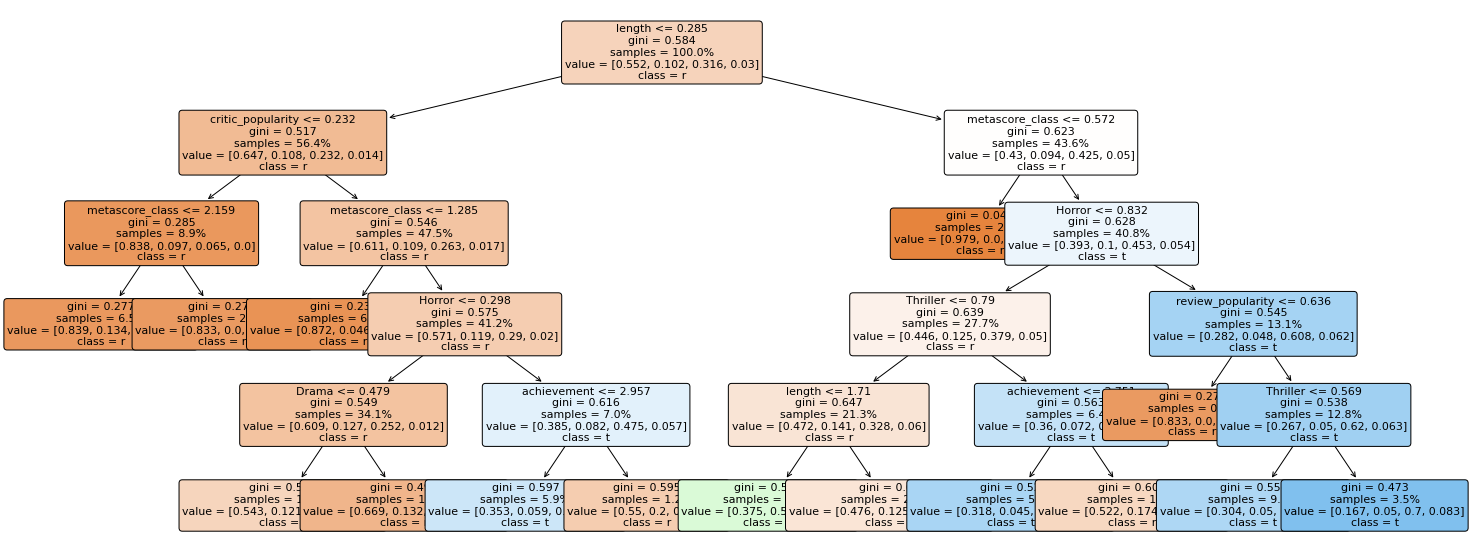

In [24]:
from sklearn import tree
import matplotlib.pyplot as plt

plt.figure(figsize=(25,10))
visualization = tree.plot_tree(
    tree_classifier, 
    feature_names = df_features.columns.tolist(), 
    class_names = 'rating_class', 
    proportion = True,
    rounded = True, 
    filled = True, 
    fontsize = 11
)
